In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from imblearn.over_sampling  import SMOTE
import xgboost
from sklearn.utils import class_weight
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout, Input, Embedding, Reshape, Concatenate, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping
import time

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
raw_data = pd.read_csv('final_wth_outliners_plus.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
raw_data.head()


,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
1,3,87,43000,16700,1,2014,1,1,9611.0,18267.0,0.0,3.274,0.0,0.000,0.707,0.293,0.162,45.959,494.252874
2,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
3,4,74,73000,9220,1,2014,1,2,1157.0,18233.0,0.0,3.086,0.0,0.000,0.865,0.135,1.564,42.764,986.486486
4,5,92,150000,80500,1,2014,1,2,12900.0,18641.0,0.0,2.698,0.0,0.450,0.354,0.197,2.567,49.650,1630.434783


In [4]:
Y = raw_data['Nombre pieces principales']
Y = list(Y)
df= raw_data.copy()
for i, m in enumerate(Y):
    if m >= 7:
        Y[i] = 7
    elif m<=1:
        Y[i] = 1

df.drop('Nombre pieces principales', axis = 1, inplace = True)
df.insert(loc=0, column='Nombre pieces principales', value=Y)

del Y
df.head()

,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
1,3,87,43000,16700,1,2014,1,1,9611.0,18267.0,0.0,3.274,0.0,0.000,0.707,0.293,0.162,45.959,494.252874
2,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
3,4,74,73000,9220,1,2014,1,2,1157.0,18233.0,0.0,3.086,0.0,0.000,0.865,0.135,1.564,42.764,986.486486
4,5,92,150000,80500,1,2014,1,2,12900.0,18641.0,0.0,2.698,0.0,0.450,0.354,0.197,2.567,49.650,1630.434783


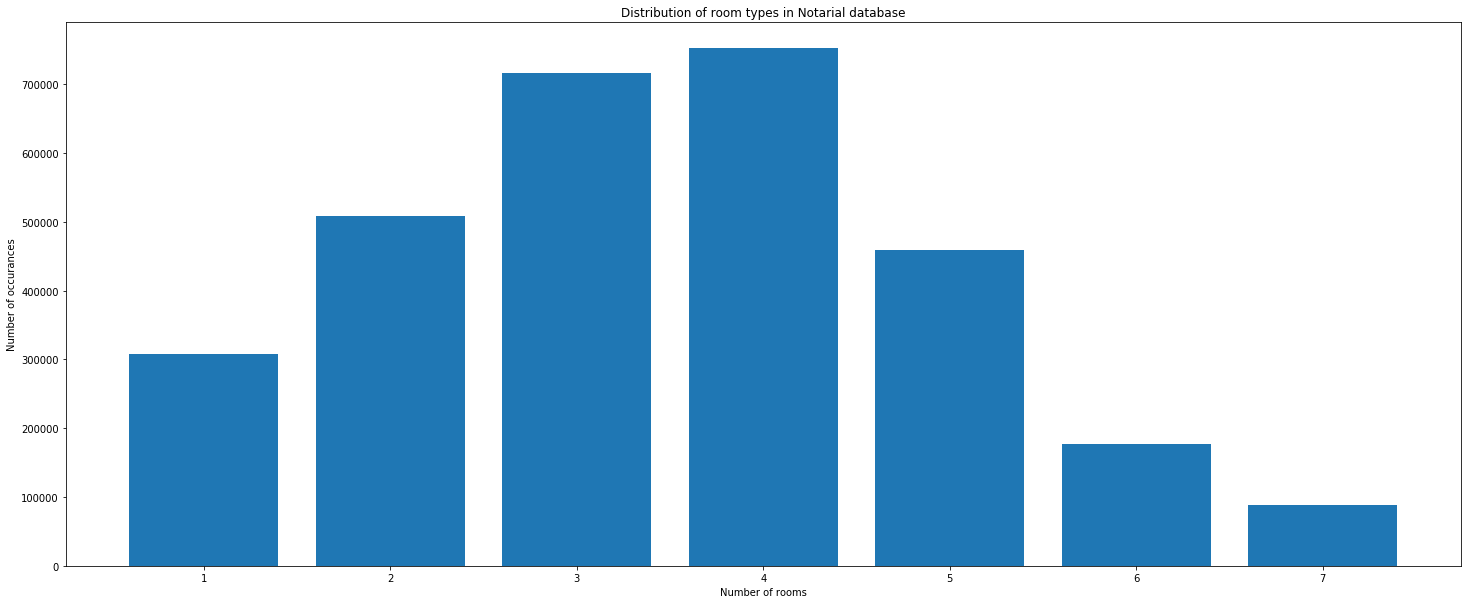

In [5]:
Y = df['Nombre pieces principales']

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

i = 0
for rect in bars:
    if rect.get_height() < 5000:
        h = 20000**(i%2)
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height+h, '%d' % int(height), ha='center', va='bottom')
        i += 1

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

In [6]:
columns = raw_data.columns

In [7]:
columns

Index(['Nombre pieces principales', 'Surface reelle bati', 'Valeur fonciere',
       'Code postal', 'Code type local', 'year', 'month', 'day', 'P15_POP',
       'MED14', 'nombre de redevables', 'Typo degré de densité',
       'Part population dense (1)', 'Part population intermédiaire (2)',
       'Part population peu dense (3)', 'Part population très peu dense (4)',
       'Longitude', 'Latitude', '€/m2'],
      dtype='object')

In [8]:
x_colums = ['Surface reelle bati', 'Valeur fonciere',
       'Code postal', 'Code type local', 'year', 'month', 'day', 'P15_POP',
       'MED14', 'nombre de redevables', 'Typo degré de densité',
       'Part population dense (1)', 'Part population intermédiaire (2)',
       'Part population peu dense (3)', 'Part population très peu dense (4)',
       'Longitude', 'Latitude', '€/m2']
y_column = 'Nombre pieces principales'

In [9]:
test_data = raw_data[raw_data['Nombre pieces principales'].isin([3,4])]

In [10]:
y_data = test_data['Nombre pieces principales'].values
X_data = test_data[x_colums]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [14]:
len(X_train)

984515

In [15]:
data = raw_data[raw_data['Nombre pieces principales'].isin([1,2,5,6,7])]

In [21]:
X_data = data[x_colums]
y_data = data[y_column]

In [24]:
data_bis= np.concatenate((X_data,X_train), axis=0)

In [25]:
targets = np.concatenate((y_data, y_train), axis=0)

In [26]:
dataset = np.concatenate((data_bis,targets), axis=1)

ValueError: all the input arrays must have same number of dimensions

In [29]:
dataset = pd.DataFrame(data_bis, columns=x_colums)

In [30]:
inputs_stdsc =dataset[['Valeur fonciere', 'Code type local',
                        'year', 'month', 'day', 'P15_POP', 'MED14','Part population dense (1)',
                        'Part population intermédiaire (2)', 'Part population peu dense (3)',
                        'Part population très peu dense (4)', 'Longitude', 'Latitude']].values
inputs_mmsc = dataset[['Surface reelle bati','nombre de redevables','Typo degré de densité']].values

In [31]:
sc = StandardScaler()
mms= MinMaxScaler()
inputs_stdsc = sc.fit_transform(inputs_stdsc)
inputs_mmsc = mms.fit_transform(inputs_mmsc)

In [32]:
codes_postaux = dataset['Code postal'].values

In [33]:
scaled_values = np.concatenate((np.reshape(codes_postaux,(-1,1)),inputs_stdsc, inputs_mmsc), axis=1)

In [34]:
cols_to_use = ['Code postal','Valeur fonciere', 'Code type local',
                        'year', 'month', 'day', 'P15_POP', 'MED14','Part population dense (1)',
                        'Part population intermédiaire (2)', 'Part population peu dense (3)',
                        'Part population très peu dense (4)', 'Longitude', 'Latitude','Surface reelle bati','nombre de redevables','Typo degré de densité']
len(cols_to_use)

17

In [35]:
scaled_data = pd.DataFrame(data=scaled_values, columns = cols_to_use)
scaled_data.head()

,Code postal,Valeur fonciere,Code type local,year,month,day,P15_POP,MED14,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,Surface reelle bati,nombre de redevables,Typo degré de densité
0,83640.0,0.150590,-0.87779,-1.480904,-1.540378,-1.817235,-0.537591,0.405663,-0.737355,0.963412,0.117175,-0.419691,1.286107,-1.552239,0.055118,0.0,0.425667
1,83640.0,0.150590,-0.87779,-1.480904,-1.540378,-1.817235,-0.537591,0.405663,-0.737355,0.963412,0.117175,-0.419691,1.286107,-1.552239,0.055118,0.0,0.425667
2,80500.0,-0.292018,-0.87779,-1.480904,-1.540378,-1.705404,-0.466411,-0.602776,-0.737355,0.480422,0.089103,0.912654,0.106308,1.219520,0.102362,0.0,0.566000
3,9000.0,-0.218250,-0.87779,-1.480904,-1.540378,-1.705404,-0.383077,-0.253184,-0.737355,0.771882,0.136826,0.026825,-0.255871,-1.694841,0.204724,0.0,0.489667
4,30360.0,-0.070714,-0.87779,-1.480904,-1.540378,-1.705404,-0.541542,-0.397795,-0.737355,-0.768692,1.526407,0.458937,0.703324,-1.247727,0.137233,0.0,0.701667


In [53]:
targets = pd.DataFrame(targets, columns=[y_column])
targets =  pd.get_dummies(targets['Nombre pieces principales']).values

In [54]:
targets

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(scaled_values, targets, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), random_state=42)
X_train = pd.DataFrame(X_train, columns=cols_to_use)
X_val = pd.DataFrame(X_val, columns=cols_to_use)
X_test = pd.DataFrame(X_test, columns=cols_to_use)

In [56]:
embed_cols = ['Code postal']

In [57]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test 



input_list_train, input_list_val, input_list_test= preproc(X_train, X_val, X_test)

In [58]:
num_numeric_values = inputs_mmsc.shape[1]+inputs_stdsc.shape[1]
num_numeric_values

16

In [59]:
def NN_model(hidden_layers, size_hl):
    inputs=[]
    embeddings = []
    for categorical_var in embed_cols :
     
        no_of_unique_cat  = X_train[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        input_cat =  Input(shape=(1,))
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(input_cat)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        inputs.append(input_cat)
        embeddings.append(embedding)

    input_numeric = Input(shape=(num_numeric_values,))
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    
    for hidden_layer in range(hidden_layers):
        if hidden_layer==1:
            x = Dense(int(size_hl*(1.75)), activation='linear')(x)
            x = Activation(LeakyReLU(0.05))(x)
            x = Dropout(.1)(x)
            x = BatchNormalization()(x)
        else:
            if hidden_layer%2==0:
                x = Dense(int(size_hl*(1.5)), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
            elif hidden_layer%2==1:
                x = Dense(int(size_hl*0.5), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
            
        
    output = Dense(7, activation='softmax')(x)
    model = Model(inputs, output)    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model


In [60]:
model = NN_model(hidden_layers=2, size_hl=200)


model.fit(input_list_train,y_train,
          epochs=2, batch_size=32,validation_data=(input_list_val,y_val),
          verbose=1)



C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.cast instead.
Train on 1989813 samples, validate on 248727 samples
Epoch 1/2
1989813/1989813 [==============================] - 626s 315us/step - loss: 1.0977 - acc: 0.5316 - val_loss: 1.0472 - val_acc: 0.5557
Epoch 2/2
1989813/1989813 [==============================] - 623s 313us/step - loss: 1.0500 - acc: 0.5546 - val_loss: 1.0320 - val_acc: 0.5586


Normalized confusion matrix
[[5.97570440e-01 3.55728024e-01 3.27990552e-02 9.17833643e-03
  4.42044879e-03 1.68719420e-04 1.34975536e-04]
 [6.36766880e-02 7.23528832e-01 1.66091671e-01 3.41843273e-02
  1.22424840e-02 1.97141449e-04 7.88565796e-05]
 [1.11574858e-03 1.72093888e-01 5.31075664e-01 2.19451217e-01
  7.53336915e-02 7.02508368e-04 2.27282119e-04]
 [9.95361615e-05 8.52029542e-03 1.80518782e-01 4.82033723e-01
  3.22636514e-01 5.09625147e-03 1.09489778e-03]
 [4.35426282e-05 9.36166507e-04 2.58207785e-02 2.49629888e-01
  6.89192720e-01 2.77584255e-02 6.61847949e-03]
 [5.64047606e-05 2.25619042e-04 6.14811890e-03 6.02966890e-02
  8.02244909e-01 1.00908117e-01 3.01201421e-02]
 [0.00000000e+00 1.64609053e-04 2.30452675e-03 1.39917695e-02
  6.83621399e-01 2.01316872e-01 9.86008230e-02]]


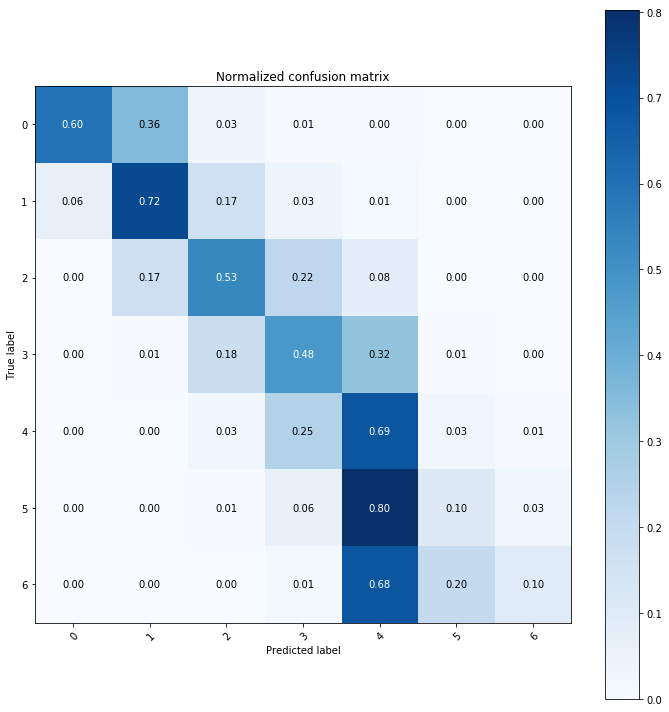

In [61]:
y_pred = model.predict(input_list_test)

plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()